In [1]:
import numpy as np
import cv2
import itertools
from matplotlib import pyplot as plt

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(image, title, cmap=None):
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.show()
    
def save_image(image, filename):
    cv2.imwrite(filename, image)

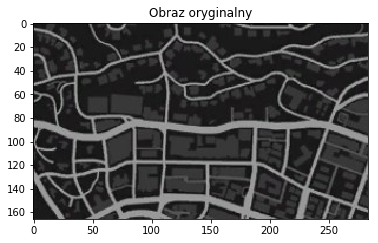

In [2]:
image = load_image('data/gtav2.jpg')
show_image(image, 'Obraz oryginalny')

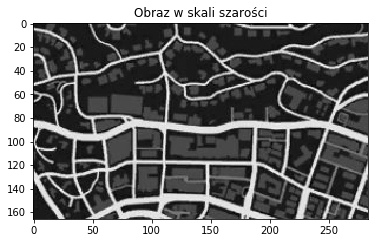

In [3]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_image(image_gray, 'Obraz w skali szarości', cmap='gray')

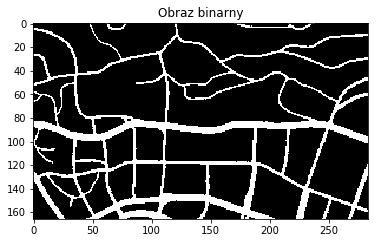

In [4]:
_, image_binary = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
show_image(image_binary, 'Obraz binarny', cmap='gray')

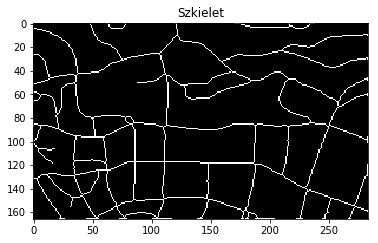

In [5]:
sk = cv2.ximgproc.thinning(image_binary, thinningType = cv2.ximgproc.THINNING_GUOHALL)
show_image(sk, "Szkielet", cmap='gray')
save_image(sk, "szkielet.png")

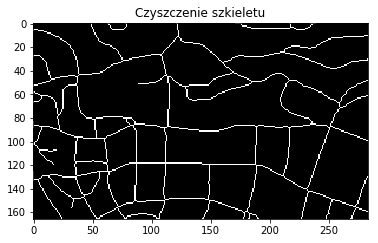

In [6]:
kernel = np.ones((2,2),np.uint8)
dilated = cv2.dilate(sk, kernel)
eroded = cv2.erode(dilated, kernel)
sk2 = cv2.ximgproc.thinning(eroded, thinningType = cv2.ximgproc.THINNING_GUOHALL)
show_image(sk2, "Czyszczenie szkieletu", cmap='gray')

save_image(sk2, "szkielet2.png")

In [7]:
def get_neighbours(image, point):
    neighbours = [
        get_point(image, point[0]-1, point[1]-1),
        get_point(image, point[0]  , point[1]-1),
        get_point(image, point[0]+1, point[1]-1),
        get_point(image, point[0]+1, point[1]  ),
        get_point(image, point[0]+1, point[1]+1),
        get_point(image, point[0]  , point[1]+1),
        get_point(image, point[0]-1, point[1]+1),
        get_point(image, point[0]-1, point[1]  )
    ]
    return neighbours

def get_point(image, x, y):
    try:
        return image[x][y]
    except:
        return 0

def count_neighbours(neighbours):
    return np.sum(neighbours)/255

def reduce_neighbours(neighbours):
    new_neighbours = []
    for i in range(0, len(neighbours)):
        prev = neighbours[i-1]
        current = neighbours[i]
        if prev != current:
            new_neighbours.append(current)
    return new_neighbours

def is_crossroad(image, point):
    if image[point[0]][point[1]] != 255:
        return False
    neighbours = get_neighbours(image, point)
    reduced = reduce_neighbours(neighbours)
    count = count_neighbours(reduced)
    return count >= 3

def is_tip(image, point):
    if image[point[0]][point[1]] != 255:
        return False
    neighbours = get_neighbours(image, point)
    reduced = reduce_neighbours(neighbours)
    count = count_neighbours(reduced)
    return count == 1

import math
def dist(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    

In [8]:
shape = sk2.shape
nodes = []
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        if is_crossroad(sk2, (i, j)) or is_tip(sk2, (i, j)):
            nodes.append((i, j))

In [9]:
filtered_nodes = []
distances = []
rem = []
for pair in itertools.combinations(nodes, 2):
    distances.append(dist(pair[0], pair[1]))
    if dist(pair[0], pair[1]) < 2:
        rem.append(pair[1])
filtered_nodes = [node for node in nodes if node not in rem]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


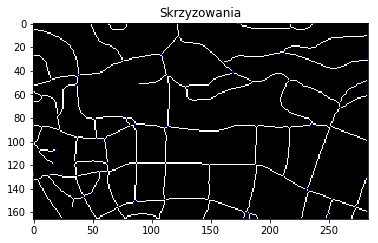

In [10]:
new_img = np.zeros((shape[0], shape[1], 3))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        new_img[i][j] = [sk2[i][j], sk2[i][j], sk2[i][j]]
for node in filtered_nodes:
    new_img[node[0]][node[1]] = [0, 0, 255]
    
show_image(new_img, "Skrzyzowania")
save_image(new_img, 'crossroads.png')

In [12]:
def set_neighbours(image, point, value=255):
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            try:
                image[point[0]+i][point[1]+j] = value
            except:
                pass
    return image

from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
def astar(image, nodes, node1, node2, debug_print=False):
    for node in nodes:
        image = set_neighbours(image, node, 0)
    image = set_neighbours(image, node1, 255)
    image = set_neighbours(image, node2, 255)
    
    grid = Grid(matrix=image)
    start = grid.node(node1[1], node1[0])
    end = grid.node(node2[1], node2[0])
    finder = AStarFinder(diagonal_movement=DiagonalMovement.always)
    path, runs = finder.find_path(start, end, grid)
    if debug_print:
        print('operations:', runs, 'path length:', len(path))
        print(grid.grid_str(path=path, start=start, end=end))
        
    return len(path)

In [17]:
edges = []
node_range = range(0, len(filtered_nodes))
for pair in itertools.combinations(node_range, 2):
    i = pair[0]
    j = pair[1]
    if i == j:
        continue
    path_len = astar(sk2, filtered_nodes, filtered_nodes[i], filtered_nodes[j])
    if path_len == 0:
        continue
    edges.append((i, j, path_len))

!!! found connection between node 0 and 16 !!!
!!! found connection between node 1 and 2 !!!
!!! found connection between node 3 and 11 !!!
!!! found connection between node 4 and 8 !!!
!!! found connection between node 5 and 8 !!!
!!! found connection between node 6 and 7 !!!
!!! found connection between node 6 and 8 !!!
!!! found connection between node 9 and 19 !!!
!!! found connection between node 10 and 12 !!!
!!! found connection between node 11 and 13 !!!
!!! found connection between node 11 and 17 !!!
!!! found connection between node 12 and 15 !!!
!!! found connection between node 12 and 17 !!!
!!! found connection between node 13 and 16 !!!
!!! found connection between node 13 and 20 !!!
!!! found connection between node 14 and 22 !!!
!!! found connection between node 16 and 19 !!!
!!! found connection between node 17 and 18 !!!
!!! found connection between node 18 and 25 !!!
!!! found connection between node 18 and 29 !!!
!!! found connection between node 19 and 21 !!!
!!! f

In [25]:
neighbour_mtx = np.zeros((len(filtered_nodes), len(filtered_nodes)))
for edge in edges:
    neighbour_mtx[edge[0]][edge[1]] = edge[2]
    neighbour_mtx[edge[1]][edge[0]] = edge[2]
    
for i in range(len(neighbour_mtx)):
    print(neighbour_mtx[i])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 39.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.

In [23]:
neighbour_list = {i: [] for i in range(len(filtered_nodes))}
for edge in edges:
    neighbour_list[edge[0]].append(edge[1])
    neighbour_list[edge[1]].append(edge[0])
from pprint import pprint
pprint(neighbour_list)

{0: [16],
 1: [2],
 2: [1],
 3: [11],
 4: [8],
 5: [8],
 6: [7, 8],
 7: [6],
 8: [4, 5, 6],
 9: [19],
 10: [12],
 11: [3, 13, 17],
 12: [10, 15, 17],
 13: [11, 16, 20],
 14: [22],
 15: [12],
 16: [0, 13, 19],
 17: [11, 12, 18],
 18: [17, 25, 29],
 19: [9, 16, 21],
 20: [13, 26, 29, 45],
 21: [19, 22, 27],
 22: [14, 21, 28],
 23: [25, 34, 41],
 24: [34],
 25: [18, 23, 29],
 26: [20],
 27: [21, 36, 38],
 28: [22],
 29: [18, 20, 25, 45],
 30: [31],
 31: [30, 33, 36],
 32: [35],
 33: [31],
 34: [23, 24, 35],
 35: [32, 34, 47],
 36: [27, 31, 51],
 37: [38, 40, 43],
 38: [27, 37, 53],
 39: [42],
 40: [37, 43, 49, 61],
 41: [23, 47, 50, 76],
 42: [39, 44, 48],
 43: [37, 40, 54, 61],
 44: [42, 48, 51, 56],
 45: [20, 29, 46, 49],
 46: [45, 50, 65],
 47: [35, 41, 55, 76],
 48: [42, 44],
 49: [40, 45, 62],
 50: [41, 46, 71],
 51: [36, 44, 52],
 52: [51, 53, 59],
 53: [38, 52, 54],
 54: [43, 53, 60],
 55: [47],
 56: [44, 57],
 57: [56, 58, 63],
 58: [57],
 59: [52, 60, 70],
 60: [54, 59, 68],
 61:

In [58]:
def draw_line(base_image, p1, p2):
    image = base_image.copy()
    return cv2.line(image, tuple(reversed(p1)), tuple(reversed(p2)), color=(255, 0, 0), thickness=2)

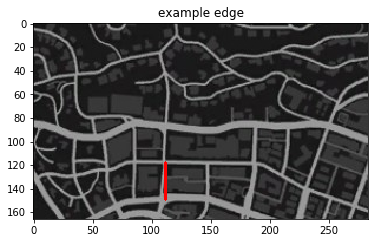

In [59]:
example = draw_line(image, filtered_nodes[62], filtered_nodes[81])
show_image(example, "example edge")